# Embedded Transformations within yt_xarray

data commonly in geographic coordinates.

## An example with 3D geographic data 



In [1]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray import transformations as tf
from yt_xarray.utilities.logging import ytxr_log
import numpy as np 
import cartopy
from yt.visualization.volume_rendering.render_source import LineSource
from dask import delayed, compute
import shapely
import cartopy.feature as cfeature
from merra2_assistant.main import plot_tf
import matplotlib.pyplot as plt 
import unyt

In [2]:
ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
grid_resolution = (32, 32, 32)
gc = tf.GeocentricCartesian(radial_type='depth', r_o=6371., use_neg_lons=True)
ds_yt = tf.build_interpolated_cartesian_ds(
    ds,
    gc,
    fields = 'dvs' ,   
    grid_resolution = grid_resolution, 
    refine_grid=True,    
    refine_max_iters=2000,
    refine_min_grid_size=4,
    refine_by=4,
    interp_method='interpolate',
)

yt_xarray : [INFO ] 2024-05-02 15:59:46,235:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-05-02 15:59:46,673:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-05-02 15:59:46,750:  Decomposed into 949 grids after 1177 iterations.
yt : [INFO     ] 2024-05-02 15:59:46,825 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-02 15:59:46,826 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-05-02 15:59:46,827 Parameters: domain_left_edge          = [-3271. -5573.  2533.]
yt : [INFO     ] 2024-05-02 15:59:46,827 Parameters: domain_right_edge         = [ -334. -2832.  4870.]
yt : [INFO     ] 2024-05-02 15:59:46,828 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-05-02 15:59:47,426 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-05-02 15:59:47,426 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-05-02 15:59:47,428 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-05-02 15:59:47,429 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-05-02 15:59:47,431 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



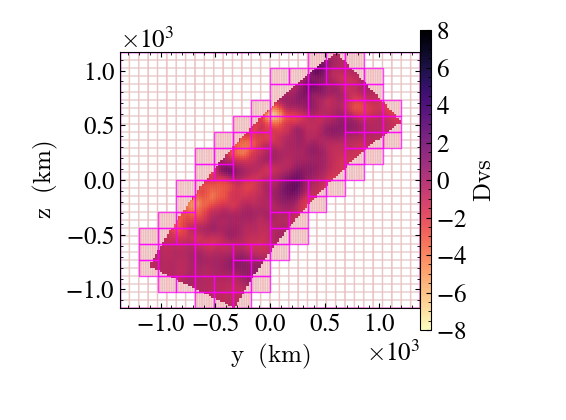

yt : [INFO     ] 2024-05-02 15:59:48,111 Saving plot slice_images/w_us_tomography.png


['slice_images/w_us_tomography.png']

In [3]:
slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(3,3))
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 8)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()
slc.save("slice_images/w_us_tomography.png")

add a field to return abs(dvs<0)

In [4]:

def _slow_vels(field, data):    
    dvs = data['dvs'].d.copy()
    dvs[np.isnan(dvs)] = 0.0
    dvs[dvs>0] = 0.0
    return unyt.unyt_array(np.abs(dvs),"")

ds_yt.add_field(
    name=("stream", "slow_dvs"),
    function=_slow_vels,
    sampling_type="local",
    units="",    
)

volume render: use the yt_xarray transformer to easily create a yt `LineSource` in the correct cartesian coordinates. Using dask here to process NaturalEarth state boundaries accessed via cartopy

In [5]:
from merra2_assistant.main import build_state_line_sources 

lsrc = build_state_line_sources(gc)

now ready for the volume rendering

yt : [INFO     ] 2024-05-02 15:59:48,409 Rendering scene (Can take a while).
yt : [INFO     ] 2024-05-02 15:59:48,414 Creating volume
yt : [INFO     ] 2024-05-02 15:59:58,239 Creating transfer function


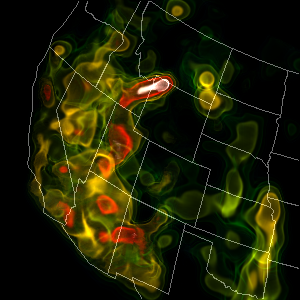

In [6]:
reg = ds_yt.region(ds_yt.domain_center, 
                   ds_yt.domain_left_edge, 
                   ds_yt.domain_right_edge)
sc = yt.create_scene(reg, field=('stream', 'slow_dvs'))
cam = sc.add_camera(ds_yt)

# transfer function 
source = sc[0]
source.tfh.set_bounds((0.1, 8))
source.tfh.set_log(True)

# add state outlines
sc.add_source(lsrc)

# adjust camera
cam.zoom(2)
cam.yaw(100*np.pi/180)
cam.roll(220*np.pi/180)
cam.rotate(30*np.pi/180)
cam.set_resolution((300,300))

sc.show(sigma_clip=5.)

In [15]:
sc.save_annotated('volume_rendering_images/wus_tomo_annotated.png', 
                  sigma_clip=5.)

yt : [WARNING  ] 2024-05-02 16:04:18,394 Previously rendered image exists, but rendering anyway. Supply 'render=False' to save previously rendered image directly.
yt : [INFO     ] 2024-05-02 16:04:18,395 Rendering scene (Can take a while).
yt : [INFO     ] 2024-05-02 16:04:19,303 Saving rendered image to volume_rendering_images/wus_tomo_annotated.png


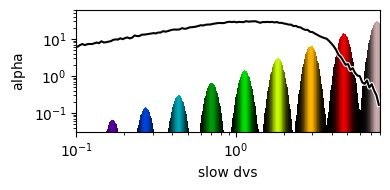

In [8]:
import os 
f, axs = plt.subplots(1, figsize=(4,2))
plot_tf(source.tfh,  profile_field=('index', 'ones'))
axs.set_xlabel('slow dvs')
plt.tight_layout()
tf_file = os.path.join('volume_rendering_images', "wus_tf.png")
f.savefig(tf_file)

In [9]:
sc.save('volume_rendering_images/w_us_tomo_vr.png',sigma_clip=5., render=False)

yt : [INFO     ] 2024-05-02 16:00:05,049 Found previously rendered image to save.
yt : [INFO     ] 2024-05-02 16:00:05,050 Saving rendered image to volume_rendering_images/w_us_tomo_vr.png


In [10]:
ds_yt_full = ds.yt.load_grid()

yt_xarray : [INFO ] 2024-05-02 16:00:05,097:  Inferred geometry type is geodetic. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2024-05-02 16:00:05,098:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2024-05-02 16:00:05,098:      stretched grid detected: yt_xarray will interpolate.
yt : [INFO     ] 2024-05-02 16:00:05,145 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-02 16:00:05,145 Parameters: domain_dimensions         = [ 18  92 121]
yt : [INFO     ] 2024-05-02 16:00:05,145 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2024-05-02 16:00:05,146 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2024-05-02 16:00:05,146 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-05-02 16:00:05,216 xlim = -125.750000 -95.500000
yt : [INFO     ] 2024-05-02 16:00:05,216 ylim = 27.500000 50.500000
yt : [INFO     ] 2024-05-02 16:00:05,217 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2024-05-02 16:00:05,219 xlim = -125.750000 -95.500000
yt : [INFO     ] 2024-05-02 16:00:05,219 ylim = 27.500000 50.500000
yt : [INFO     ] 2024-05-02 16:00:05,222 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



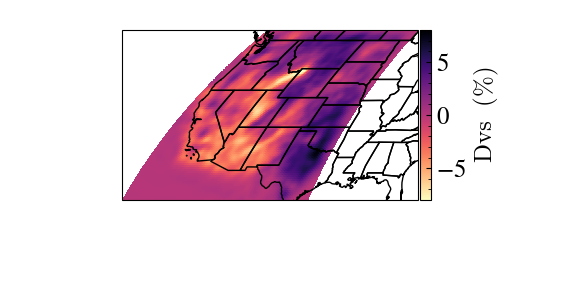

yt : [INFO     ] 2024-05-02 16:00:06,979 Saving plot slice_images/w_us_tomography_carto_100km.png


['slice_images/w_us_tomography_carto_100km.png']

In [11]:
c = ds_yt_full.domain_center.copy()
c[0] = 100
slc = yt.SlicePlot(ds_yt_full, 'depth', 'dvs',center=c, window_size=(3,1.7))
slc.set_zlim('dvs', -8,8)
slc.set_log('dvs', False)
slc.set_cmap("dvs", "magma_r")
slc.render()
slc.plots['dvs'].axes.add_feature(cfeature.STATES)
slc.show()
slc.save('slice_images/w_us_tomography_carto_100km.png')

In [12]:
from shutil import copyfile
import os 

files_to_copy = [os.path.join('slice_images','w_us_tomography.png'),
                 os.path.join('slice_images','w_us_tomography_carto_100km.png'),                 
                os.path.join('volume_rendering_images','wus_tomo_annotated.png')]
dest_folder = os.path.join('..','yt_xr_2024','_static', 'images')

for fi in files_to_copy:
    dest_fi = os.path.join(dest_folder, os.path.basename(fi))
    copyfile(fi, dest_fi)
